# Projeto 1 - Confiabilidade

Um sistema requer $n$ máquinas para funcionar. Elas quebram, a cada unidade de tempo (um minuto), com
probabilidade $p_0$. Para garantir o funcionamento confiável do sistema, $s$ máquinas adicionais são mantidas para
reposição. Quando uma máquina quebra, ela é substituída por uma em bom estado e enviada para reparo. O
tempo de reparo de cada máquina  ́e $tR$ (fixo).

Deseja-se estudar a variável aleatória “tempo de colapso” do sistema, isto  ́e, o tempo $T$ que o sistema funciona
até dever ser parado porque não há $n$ máquinas disponíveis. Quanto vale $E(T)$? Qual é a distribuição de $T$?
Como depende a variável $T$ do número de máquinas reserva $s$? Mais em concreto, quantas máquinas adicionais
são necessárias para que Prob{$T < 10000$} seja menor que 1%?

Faixas sugeridas de valores: $n = 10 − 100$, $p_0 = 0.001 − 0.01$, $s = 10 − 100$.

1. Quais das perguntas acima conseguem responder analiticamente? Nos casos que possa, qual  ́e o resultado?
2. Os resultados do simulador são consistentes com as estimações analíticas no caso $\beta = 0$?
3. No simulador,  ́e fácil inserir a amostragem de outras variáveis aleatórias. Estudar por exemplo a variável $Z$ que
podemos chamar “tempo de alerta”, definido como o tempo em que o número de máquinas em reparação atinge
80% do valor disponível $s$ (ou outra porcentagem a escolher). Como é a distribuição de probabilidade de $Z$?
4. São $Z$ e $T$ variáveis independentes?  ́E possível predizer em alguma medida o tempo de colapso uma vez que foi
atingido o tempo de alerta? Se uma parada ordenada do sistema requer o tempo $t_R$ , pode sugerir uma estratégia
de manejo que “garanta” chegar a parada ordenada com 99% de probabilidade?
5. É lógico que as máquinas envelheçam. A probabilidade de cada máquina de falhar pode crescer linearmente com
o tempo, seguindo $p(k) = p_0 + \beta t_f(k)$ onde $k$ identifica a máquina e $tf(k)$ o tempo que ela leva em funcionamento
desde o  ́ultimo reparo. No caso de $β \ne 0$  ́e impossível realizar cálculos analíticos sobre a variável $T$. Para isto,
desenvolver um pequeno código de simulação do processo. Esse caso é mais complexo que o original, porque é
necessário armazenar informação específica para cada máquina (o tempo que leva trabalhando). Mesmo assim,
trata-se apenas de uma adequada combinação de variáveis Bernoulli que o computador sabe simular.

## Libs & Utils

In [16]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy as sc
import scipy.stats as st
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import json
import os
from typing import List, Tuple, Callable, Dict
from collections import defaultdict


## Modelagem Analítica

Para seguir com a modelagem analítica, precisamos simplificar alguns aspectos do problema, para isso assumiremos:

1. $t_R \to \infty$
2. $\beta = 0$

A binomial negativa (desconsiderando as $s$ primeiras trials) (mesma do scipy):

$$
p_1(t; s, p) = \begin{pmatrix}t + s - 1 \\ s -1\end{pmatrix} p^{s} (1 - p)^{t}
$$

A binomial negativa (considerando as $s$ primeiras trials)

$$
p_2(t; s, p) = p_1(t-s; s, p) = \begin{pmatrix}t - 1 \\ s -1\end{pmatrix} p^{s} (1 - p)^{t - s}
$$

Importante notar que em cada ciclo do sistema, teríamos $n$ trials, então para obter a chance de falhar no $k$-ésimo ciclo, precisaríamos de:

$$
p_3(k; n, s, p) = \sum^{n}_{i = 1} p_2(n \cdot (k - 1) + i; s, p)
$$

**Importante**

Para nosso problema, precisamos saber o número de trials antes da $s_0+1$ falha! 

---

Seria possível simplificar esse somatório?

<!-- Iremos comparar nossos resultados analíticos com os obtidos em $10000$ cenários simulados com os seguintes parâmetros:

- $n = 50$, $p_0 = 0.006$, $s = 10$ -->

### Analytical Utils

In [4]:
k, t, i, n, s, p = sp.symbols("k t i n s p")
neg_binomial_exp = sp.binomial(t - 1, s - 1) * (p ** s) * (1 - p) ** (t - s) # Negative Binomial
neg_binomial_exp = neg_binomial_exp.subs(s, s + 1) # Fix r to s definition
p_sum_exp = sp.Sum(neg_binomial_exp.subs(t, n * (k - 1) + i), (i, 1, n)) # Group trials in same day

In [5]:
def make_distribution_pdf(n, s, p):
    s += 1
    base_dist = st.nbinom(s, p)
    return lambda k: sum(base_dist.pmf(n * (k - 1) + i - s) for i in range(1, n+1))
    # return lambda x: p_sum_exp.subs({
    #     'k': x,
    #     'n': n,
    #     's': s,
    #     'p': p
    # }).evalf()
    # f = lambda k: sp.binomial(k - 1, s - 1).evalf() * p ** s * (1 - p) ** (k - s)
    # return lambda k: (sum(f(n * (k - 1) + i) for i in range(1, n + 1)))
    

## Simulação

### Simulation Utils

In [17]:
# Python-based simulator
from simulator.simulator import INF, factory_trial, multiple_trials

datasets_path = './datasets/'

# Load simulations from dir
def load_sims(dir_name):
    target_dir = os.path.join(datasets_path, dir_name)
    sims = []
    for target in os.listdir(target_dir):
        target_path = os.path.join(target_dir, target)
        if not os.path.isfile(target_path):
            continue

        if target.endswith('.json'):
            with open(target_path, 'r') as fp:
                sims.append(json.load(fp))

    return sims


# Generate PDF Dict from Simulation Results
def sim_pdf(results: List[int]):
    counts = defaultdict(lambda: 0)
    for r in results:
        counts[r] += 1
    return {k: v/len(results) for k, v in sorted(counts.items())}


# Plot Simulation Results PDF
def plot_trial(results: List[int], interpolate: bool = False, *args, **kwargs):
    pdf = sim_pdf(results)

    x = list(pdf.keys())
    y = list(pdf.values())

    if interpolate:
        cubic_interpolation = interp1d(x, y, kind="cubic")

        x = np.linspace(x[0], x[-1], 500)
        y = cubic_interpolation(x)
    
    return plt.plot(x, y, *args, **kwargs)

### Result Utils

In [24]:
def compare_models(x_range: Tuple[int, int], pdf: Callable[[int], float], sims: List[Dict], interpolate_pdf: bool = True, interpolate_sims: bool = True):
    plt.figure(figsize=(18,10))
    plt.xlim(x_range)

    # Plot Simulations
    for i, sim_data in enumerate(sims):
        plot_trial(sim_data['results'], label=f"Simulation {i+1}", linestyle="--", interpolate=interpolate_sims)

    # Plot Analytical Model
    x = list(range(x_range[0], x_range[1] + 1))
    y = [pdf(i) for i in x]

    if interpolate_pdf:
        cubic_interpolation = interp1d(x, y, kind="cubic")

        x = np.linspace(x[0], x[-1], 500)
        y = cubic_interpolation(x)


    plt.plot(x, y, label="Analytical Model", linestyle="-", color="red")

    plt.legend()
    plt.show()

### Resultados para $n=50$, $s=10$, $p=0.006$

In [9]:
pdf_50_0006_10 = make_distribution_pdf(50, 10, 0.006) # Analytical PDF
sims_50_0006_10 = load_sims('50-0_006-10') # Simulation Results

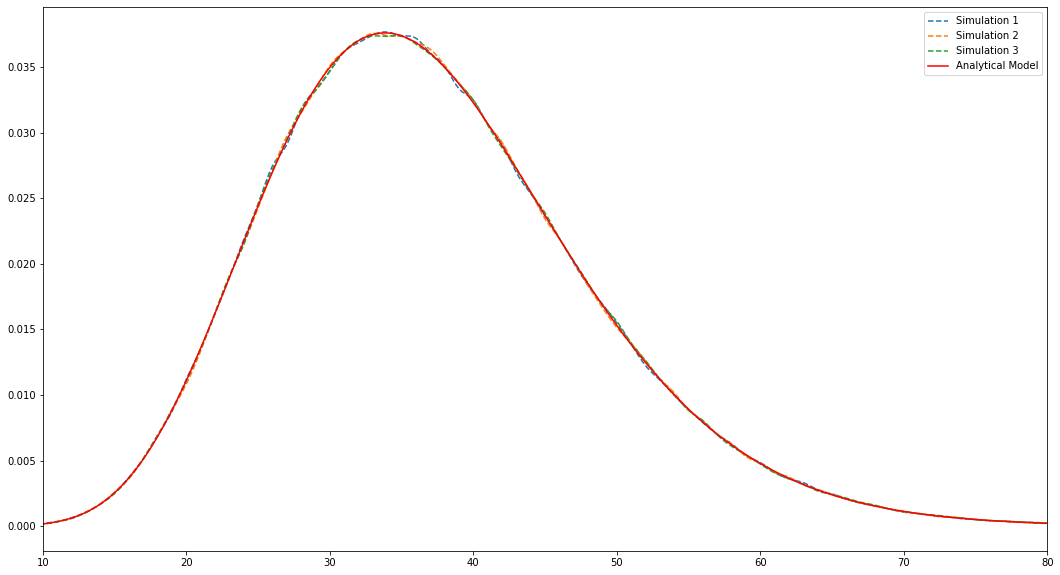

In [28]:
compare_models((10, 80), pdf_50_0006_10, sims_50_0006_10)

### Resultados para $n=100$, $s=25$, $p=0.01$

In [11]:
pdf_100_001_25 = make_distribution_pdf(100, 25, 0.01) # Analytical PDF
sims_100_001_25 = load_sims('100-0_01-25') # Simulation Results

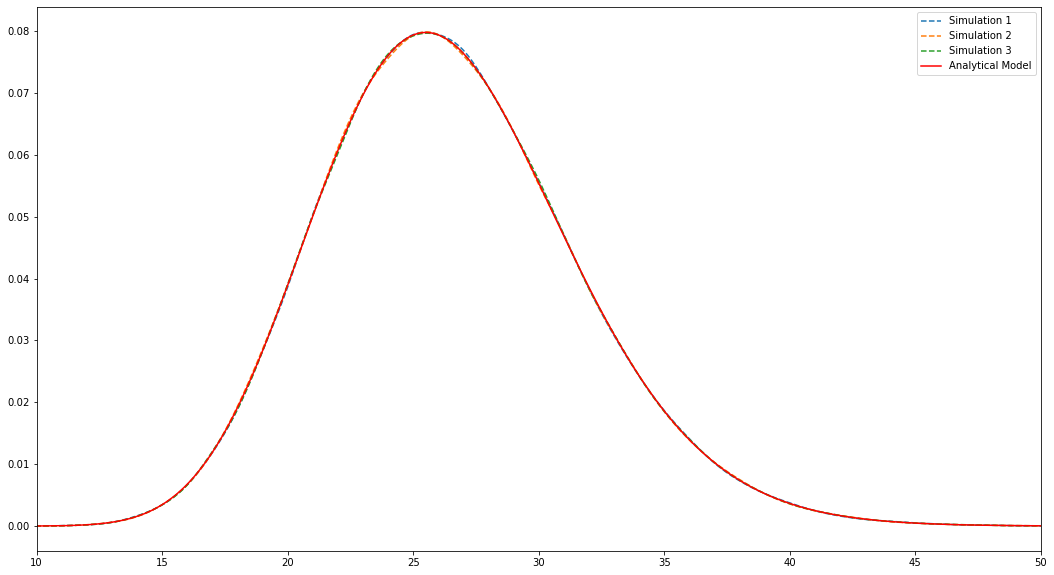

In [27]:
compare_models((10, 50), pdf_100_001_25, sims_100_001_25)